In [1]:
### Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.metrics import davies_bouldin_score

In [2]:
### Read CSV file & Future Formatting
df_data = pd.read_csv("data.csv")
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = "{:.2f}".format

In [3]:
### Data introduction
# Identify unnecessary and target columns
DROP_LABELS = ["Flow ID", "Src IP", "Src Port", "Dst IP", "Dst Port", "Timestamp"]
TARGET_LABELS = ["Label", "Traffic Type", "Traffic Subtype"]

# Split training and testing data
def split_data(df: pd.DataFrame, target: str) -> tuple:
    X = df.copy()
    Y = df[target]

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=1/3)
    return x_train, x_test, y_train, y_test

# Sampling

def oversample(df: pd.DataFrame, target: str) -> pd.DataFrame:
    x = df.drop(columns=target)
    y = df[target]

    ROS = RandomOverSampler(sampling_strategy="auto")
    x_res, y_res = ROS.fit_resample(x, y)
    return x_res, y_res

def sampling(df: pd.DataFrame, rate: float, cap1=0, cap2=0, notext=False) -> pd.DataFrame:
    if notext == False:
        print("Dataset before sampling has", df.shape[0], "rows and", df.shape[1], "columns")
        print("Sampling ...")

    if cap1 != 0:
        subtype_counts = df["Traffic Subtype"].value_counts()  # All the traffic subtypes
        if cap2 != 0:
            subtypes_sampling1 = subtype_counts[(subtype_counts > cap1) & (subtype_counts < 10*cap2)].index
            subtypes_sampling2 = subtype_counts[subtype_counts >= 10*cap2].index
        
        else:
             subtypes_sampling = subtype_counts[subtype_counts > cap1].index
        subtypes_nosampling = subtype_counts[subtype_counts <= cap1].index # All the traffic subtypes with under x rows
        
        if cap2 != 0:
            df_sampling1 = df[df["Traffic Subtype"].isin(subtypes_sampling1)]
            df_sampled1 = df_sampling1.sample(frac=rate)
            df_sampling2 = df[df["Traffic Subtype"].isin(subtypes_sampling2)]
            df_sampled2 = df_sampling2.sample(frac=rate/10)
            df_notsampled = df[df["Traffic Subtype"].isin(subtypes_nosampling)]   # DataFrame for rest of traffic types
            df_final =  pd.concat([df_sampled1, df_sampled2, df_notsampled], ignore_index=True)  # Final  partially sampled DataFrame

        else:
            df_sampling = df[df["Traffic Subtype"].isin(subtypes_sampling)]
            df_sampled = df_sampling.sample(frac=rate)
            df_notsampled = df[df["Traffic Subtype"].isin(subtypes_nosampling)]   # DataFrame for rest of traffic types
            df_final =  pd.concat([df_sampled, df_notsampled], ignore_index=True)  # Final  partially sampled DataFrame

    else:
        df_final = df.sample(frac=rate)
        
    if notext == False:
        print("Dataset after sampling has", df_final.shape[0], "rows and", df_final.shape[1], "columns")
    
    return df_final.sample(frac=1, ignore_index=True)

# Drop unnecessary data
def drop_unnecessary(df: pd.DataFrame) -> pd.DataFrame:
    print("Dataset before removing unnecessary data has", df.shape[0], "rows and", df.shape[1], "columns")
    print("Removing unnecessary data ...")
    df_final =  df.drop(columns=DROP_LABELS)
    print("Dataset after removing unnecessary data has", df_final.shape[0], "rows and", df_final.shape[1], "columns")
    
    return df_final

# Data presentation
def present(df: pd.DataFrame, target: str):
    print("\n\nSampled dataset with target:", target)
    print("Dataset after uniform target sampling has", df.shape[0], "rows and", df.shape[1], "columns")
    display(df.head())
    display(df.tail())
    display(df.describe().T)
    display(df.groupby([target]).size().reset_index(name="Counts"))
    display(df.groupby(TARGET_LABELS).size().reset_index(name="Counts"))

In [4]:
### Correlation, target correlation and intresting columns
LABEL_MAPPER = {"Malicious": 1, "Benign": 0}
TYPES_MAPPER = {"Audio": 0, "Background": 1, "Text": 2, "Video": 3, "Bruteforce": 4, "DoS": 5, "Information Gathering": 6, "Mirai": 7}
SUBTYPES_MAPPER = {
    "Audio": 0, "Background": 1, "Text": 2, "Video HTTP": 3, "Video RTP": 4, "Video UDP": 5, "Bruteforce DNS": 6, "Bruteforce FTP": 7, "Bruteforce HTTP": 8,
    "Bruteforce SSH": 9, "Bruteforce Telnet": 10, "DoS ACK": 11, "DoS CWR": 12, "DoS ECN": 13, "DoS FIN": 14, "DoS HTTP": 15, "DoS ICMP": 16, "DoS MAC": 17,
    "DoS PSH": 18, "DoS RST": 19, "DoS SYN": 20, "DoS UDP": 21, "DoS URG": 22, "Information Gathering": 23, "Mirai DDoS ACK": 24, "Mirai DDoS DNS": 25,
    "Mirai DDoS GREETH": 26, "Mirai DDoS GREIP": 27, "Mirai DDoS HTTP": 28, "Mirai DDoS SYN": 29, "Mirai DDoS UDP": 30, "Mirai Scan Bruteforce": 31
    }

def labels_to_numerical(df: pd.DataFrame, mapper: dict) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy["Label"] = df_copy["Label"].map(mapper)
    return df_copy

def ttypes_to_numerical(df: pd.DataFrame, mapper: dict) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy["Traffic Type"] = df_copy["Traffic Type"].map(mapper)
    return df_copy

def subtypes_to_numerical(df: pd.DataFrame, mapper: dict) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy["Traffic Subtype"] = df_copy["Traffic Subtype"].map(mapper)
    return df_copy

def correlation(df_numerical: pd.DataFrame, target: str, with_target=False):
    df_copy = df_numerical.copy()
    df_norm = (df_copy - df_copy.min()) / (df_copy.max() - df_copy.min())

    if with_target == True:
        important_metrics = []
        cor = df_norm.corr(numeric_only=True).filter([target])

        for r in cor.index.tolist():
            if abs(cor.at[r, target]) > 0.2:
                important_metrics.append(r)

        print(len(important_metrics) - 2, "Metrics with high correlation with Label")
        return cor, important_metrics

    else:
        return df_norm.corr(numeric_only=True)

In [5]:
### Data Visualization
# Create heatmap from correlation Pandas Dataframes
def heatmap(corr_dict: dict, title: str, with_target=False) -> None:
    print("Generating heatmap ...")
    
    if with_target == True:
        final_corr = pd.DataFrame()
        for target in corr_dict.keys(): final_corr[target] = corr_dict[target]
        final_corr = final_corr.T
        plt.figure(figsize=(30, 5))
        sns.heatmap(final_corr, cmap="coolwarm", square=True, cbar=False)
        plt.xticks(rotation = 65, ha = "right")

    else:
        final_corr = corr_dict["Correlation"]
        plt.figure(figsize=(30, 20))
        sns.heatmap(final_corr, cmap="coolwarm", square=True)

    plt.title(title)
    plt.show()

# Create boxplot diagram to showcase target differences
def boxplot(df: pd.DataFrame, title: str, y_lim_bot: float, y_lim_top: float, x_labels: list) -> None:
    print("Generating boxplot ...")
    df_copy = df.copy()
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_copy)
    plt.figure(figsize=(15, 5))
    sns.boxplot(data=df_scaled)
    plt.ylim((y_lim_bot, y_lim_top))
    plt.xticks(rotation = 65, ha = "right", labels=x_labels, ticks=[i for i in range(len(x_labels))])
    plt.title(title)
    plt.show()

# Create barplot to showcase certain values
def barplot(x, y, title: str) -> None:
    print("Generating barplot ...")
    plt.figure(figsize=(15, 5))
    sns.barplot(x=x, y=y)
    plt.ylim((-1, 1))
    plt.xticks(rotation = 65, ha = "right")
    plt.title(title)
    plt.grid(True, axis="y")
    plt.show()



In [6]:
### Dimensionality Reduction
PCA_COLS = [
    "PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10", "PC11", "PC12", "PC13", "PC14", "PC15", "PC16", "PC17",
    "PC18", "PC19", "PC20", "PC21", "PC22", "PC23", "PC24", "PC25", "PC26", "PC27", "PC28", "PC29", "PC30"
    ]

def dim_reduction(df: pd.DataFrame, N: int, method: str) -> pd.DataFrame:
    if method == "PCA":
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df)
        pca = PCA(n_components=N)
        principal_components = pca.fit_transform(df_scaled)
        df_final = pd.DataFrame(data=principal_components, columns=PCA_COLS[:N])
        print("PCA METHOD --> Cumulative variance:", pca.explained_variance_ratio_.cumsum()[-1])
    
    return df_final

In [7]:
### Clustering
# BIRCH Algorithm
def BIRCH_clustering(df: pd.DataFrame, N_clusters: int, threshold=0.5) -> pd.DataFrame:
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)

    model = Birch(n_clusters=N_clusters, threshold=threshold)
    model.fit(df_scaled)
    df["Cluster"] = model.labels_
    print(df["Cluster"].nunique(), "Clusters")

    cluster_index = davies_bouldin_score(df, model.labels_)
    print("Davies-Bouldin Index:", cluster_index)
    return df

# DBSCAN Algorithm
def DBSCAN_algorithm(df: pd.date_range, epsilon=0.5, min_cluster_size=5) -> pd.DataFrame:
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)

    model = DBSCAN(eps=epsilon, min_samples=min_cluster_size)
    clusters = model.fit_predict(df_scaled)
    df["Cluster"] = clusters
    print(df["Cluster"].nunique(), "Clusters")

    cluster_index = davies_bouldin_score(df, clusters)
    print("Davies-Bouldin Index:", cluster_index)
    return df

# HDBSCAN Algorithm
def HDBSCAN_clustering(df: pd.DataFrame, minimum_cluster_size=5) -> pd.DataFrame:
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)

    model = hdbscan.HDBSCAN(min_cluster_size=minimum_cluster_size)
    clusters = model.fit_predict(df_scaled)
    df["Cluster"] = clusters
    df_clean = df[df["Cluster"] != -1]
    print(df_clean["Cluster"].nunique(), "Clusters")
    
    clusters_clean = df_clean["Cluster"].to_numpy()
    cluster_index = davies_bouldin_score(df_clean, clusters_clean)
    print("Davies-Bouldin Index:", cluster_index)
    return df

# Evaluation of clusters
def evaluate_clusters(df: pd.DataFrame, target: str, subtarget: str, targets_n: int, cluster_ratio_cap=0.2):
    prediction_list = []
    counts = {}
    problematic_count = 0
    problematic_idx_count = {i: 0 for i in range(targets_n)}
    problematic_pop = 0
    empty_clusters = 0
    total_pop = len(df)
    total_clusters = df["Cluster"].nunique()
    target_total_pop = {i: 0 for i in range(targets_n)}
    target_actual_pop = {i: 0 for i in range(targets_n)}

    for cluster_id in range(total_clusters):
        class_counts = [len(df[(df["Cluster"] == cluster_id) & (df[target] == j)]) for j in range(targets_n)]
        if sum(class_counts) == 0:
            empty_clusters += 1
            continue
        dominant_class = np.argmax(class_counts)
        dominant_count = class_counts[dominant_class]
        other_count = sum(class_counts) - dominant_count
        prediction_list.append(dominant_class)
        if dominant_count == 0:
            print(class_counts)
            continue
        ratio = other_count / dominant_count
        if ratio > cluster_ratio_cap:  # Condition to identify problematic cluster
            problematic_count += 1
            problematic_pop += sum(class_counts)
            problematic_idx_count[dominant_class] += 1
        target_total_pop[dominant_class] += sum(class_counts)

    for i in range(targets_n):
        counts[i] = prediction_list.count(i)

    for i in range(targets_n):
        target_actual_pop[i] = len(df[df[target] == i])

    print("Problematic Cluster - Ratio: {0:.3f}%".format(problematic_count / total_clusters * 100))  # Ratio of clusters that are problematic
    print("Population that belongs to Problematic Clusters - Ratio: {0:.3f}%".format(problematic_pop / total_pop * 100))  # Ratio of total population that belongs to problematic clusters
    print("Clusters assigned to each {0}: {1}".format(target, counts))  # Amount of clusters that each target is assigned
    print("Problematic Clusters assigned to each {0}: {1}".format(target, problematic_idx_count)) # Amount of problematic clusters that each target is assigned
    print("Total Clusters:", total_clusters)  # Total number of clusters
    print("Empty clusters:", empty_clusters)  # Total number of empty clusters
    print("Total Population predicted per Target:", target_total_pop)  # Total population that was predicted for each target
    print("Real Population per Target:", target_actual_pop) # Real population of each target

    df_plot_x = df.groupby("Cluster")[target].mean()
    df_plot_y = df.groupby("Cluster")[subtarget].mean()

    plt.figure(figsize=(10, 6))
    plt.scatter(df_plot_x.values, df_plot_y.values, c="red", marker="x", s=100, label="Cluster Centers")
    if target == "Label":
        plt.xlim((-0.1, 1.1))
        plt.ylim((-0.5, 7.5))
    elif target == "Traffic Type":
        plt.xlim((-0.5, 7.5))
        plt.ylim((-1, 32))
    plt.xlabel(target)
    plt.ylabel(subtarget)
    plt.legend()
    plt.grid(True)
    plt.show()
    

In [8]:
### Initial undersampling/oversampling remove excess metrics and duplicates in order to create plots in reasonable time, present data
ttype_list = ["Audio", "Background", "Text", "Video", "Bruteforce", "DoS", "Information Gathering", "Mirai"]

# Undersample large traffic subtypes to decrease data size
df_sampled = sampling(df_data, rate=0.005, cap1=5000, cap2=0)
df_sampled = drop_unnecessary(df_sampled)

# Split between training and testing data
split_list_label = split_data(df_sampled, "Label")
df_train_label = split_list_label[0]
df_test_label = split_list_label[1]

split_list_ttype = split_data(df_sampled, "Traffic Type")
df_train_ttype = split_list_label[0]
df_test_ttype = split_list_label[1]

# Smoothen population by oversampling unrepresented categories
df_smoothed_label, y_train_label = oversample(df_train_label, "Label")
df_smoothed_label["Label"] = y_train_label
df_smoothed_label_benign = df_smoothed_label[df_smoothed_label["Label"] == "Benign"]
df_smoothed_label_malicious = df_smoothed_label[df_smoothed_label["Label"] == "Malicious"]
df_smoothed_label_final_b, y_train_label_final_b = oversample(df_smoothed_label_benign, "Traffic Type")
df_smoothed_label_final_b["Traffic Type"] = y_train_label_final_b
df_smoothed_label_final_m, y_train_label_final_m = oversample(df_smoothed_label_malicious, "Traffic Type")
df_smoothed_label_final_m["Traffic Type"] = y_train_label_final_m
df_smoothed_label_final = pd.concat([df_smoothed_label_final_b, df_smoothed_label_final_m], ignore_index=True)
df_smoothed_label_final = df_smoothed_label_final.sample(frac=1)

df_smoothed_ttype, y_train_ttype = oversample(df_train_ttype, "Traffic Type")
df_smoothed_ttype["Traffic Type"] = y_train_ttype

# Undersample again to get to desired data size and introduce slight randomizations
df_label = sampling(df_smoothed_label_final, rate=0.8, notext=True)
df_ttype = sampling(df_smoothed_ttype, rate=0.8, notext=True)

# Present data
present(df_label, "Label")
present(df_ttype, "Traffic Type")

Dataset before sampling has 8656767 rows and 86 columns
Sampling ...
Dataset after sampling has 61467 rows and 86 columns
Dataset before removing unnecessary data has 61467 rows and 86 columns
Removing unnecessary data ...
Dataset after removing unnecessary data has 61467 rows and 80 columns


Sampled dataset with target: Label
Dataset after uniform target sampling has 165178 rows and 80 columns


Protocol  Flow Duration  Total Fwd Packet  Total Bwd packets  \
0      0.00    85209451.00             10.00               0.00   
1      6.00    10029651.00              7.00               6.00   
2      6.00    45355709.00              2.00               1.00   
3      6.00     1907012.00              1.00               1.00   
4      6.00       74821.00              1.00               1.00   

   Total Length of Fwd Packet  Total Length of Bwd Packet  \
0                        0.00                        0.00   
1                       27.00                      112.00   
2                     1000.00                        0.00   
3                       50.00                        0.00   
4                        0.00                        0.00   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                   0.00                   0.00                    0.00   
1                  15.00                   0.00                    3.86   
2                 500.00                 500.00                  500.00   
3                  50.00                  50.00                   50.00   
4                   0.00                   0.00                    0.00   

   Fwd Packet Length Std  Bwd Packet Length Max  Bwd Packet Length Min  \
0                   0.00                   0.00                   0.00   
1                   6.64                  77.00                   0.00   
2                   0.00                   0.00                   0.00   
3                   0.00                   0.00                   0.00   
4                   0.00                   0.00                   0.00   

   Bwd Packet Length Mean  Bwd Packet Length Std  Flow Bytes/s  \
0                    0.00                   0.00          0.00   
1                   18.67                  31.82         13.86   
2                    0.00                   0.00         22.05   
3                    0.00                   0.00         26.22   
4                    0.00                   0.00          0.00   

   Flow Packets/s  Flow IAT Mean  Flow IAT Std  Flow IAT Max  Flow IAT Min  \
0            0.12     9467716.78   13544402.63   37670754.00        432.00   
1            1.30      835804.25    2888507.27   10008046.00         23.00   
2            0.07    22677854.50   31789656.24   45156536.00     199173.00   
3            1.05     1907012.00          0.00    1907012.00    1907012.00   
4           26.73       74821.00          0.00      74821.00      74821.00   

   Fwd IAT Total  Fwd IAT Mean  Fwd IAT Std  Fwd IAT Max  Fwd IAT Min  \
0    85209451.00    9467716.78  13544402.63  37670754.00       432.00   
1    10026780.00    1671130.00   4085465.53  10010550.00        23.00   
2    45156536.00   45156536.00         0.00  45156536.00  45156536.00   
3           0.00          0.00         0.00         0.00         0.00   
4           0.00          0.00         0.00         0.00         0.00   

   Bwd IAT Total  Bwd IAT Mean  Bwd IAT Std  Bwd IAT Max  Bwd IAT Min  \
0           0.00          0.00         0.00         0.00         0.00   
1    10026980.00    2005396.00   4475222.89  10010917.00        23.00   
2           0.00          0.00         0.00         0.00         0.00   
3           0.00          0.00         0.00         0.00         0.00   
4           0.00          0.00         0.00         0.00         0.00   

   Fwd PSH Flags  Bwd PSH Flags  Fwd URG Flags  Bwd URG Flags  \
0           0.00           0.00           0.00           0.00   
1           0.00           0.00           0.00           0.00   
2           0.00           0.00           0.00           0.00   
3           0.00           0.00           0.00           0.00   
4           0.00           0.00           0.00           0.00   

   Fwd Header Length  Bwd Header Length  Fwd Packets/s  Bwd Packets/s  \
0               0.00               0.00           0.12           0.00   
1             232.00             200.00           0.70  

Protocol  Flow Duration  Total Fwd Packet  Total Bwd packets  \
165173      6.00       34027.00              1.00               1.00   
165174      6.00    13524245.00             22.00              33.00   
165175      6.00     3906669.00              2.00               0.00   
165176      6.00   119996547.00           2879.00            3202.00   
165177      6.00     7652455.00              2.00               0.00   

        Total Length of Fwd Packet  Total Length of Bwd Packet  \
165173                      500.00                        0.00   
165174                     1928.00                     2185.00   
165175                        0.00                        0.00   
165176                   258125.00                   266531.00   
165177                        0.00                        0.00   

        Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
165173                 500.00                 500.00                  500.00   
165174                 880.00                   0.00                   87.64   
165175                   0.00                   0.00                    0.00   
165176                1348.00                   0.00                   89.66   
165177                   0.00                   0.00                    0.00   

        Fwd Packet Length Std  Bwd Packet Length Max  Bwd Packet Length Min  \
165173                   0.00                   0.00                   0.00   
165174                 181.06                1056.00                   0.00   
165175                   0.00                   0.00                   0.00   
165176                 144.15                1348.00                   0.00   
165177                   0.00                   0.00                   0.00   

        Bwd Packet Length Mean  Bwd Packet Length Std  Flow Bytes/s  \
165173                    0.00                   0.00      14694.21   
165174                   66.21                 183.81        304.12   
165175                    0.00                   0.00          0.00   
165176                   83.24                 109.46       4372.26   
165177                    0.00                   0.00          0.00   

        Flow Packets/s  Flow IAT Mean  Flow IAT Std  Flow IAT Max  \
165173           58.78       34027.00          0.00      34027.00   
165174            4.07      250448.98     737968.59    3299605.00   
165175            0.51     3906669.00          0.00    3906669.00   
165176           50.68       19736.27     139653.35    6121450.00   
165177            0.26     7652455.00          0.00    7652455.00   

        Flow IAT Min  Fwd IAT Total  Fwd IAT Mean  Fwd IAT Std  Fwd IAT Max  \
165173      34027.00           0.00          0.00         0.00         0.00   
165174         27.00    11869442.00     565211.52   1084238.41   3310572.00   
165175    3906669.00     3906669.00    3906669.00         0.00   3906669.00   
165176       -233.00   119803025.00      41627.18    203215.60   6155018.00   
165177    7652455.00     7652455.00    7652455.00         0.00   7652455.00   

        Fwd IAT Min  Bwd IAT Total  Bwd IAT Mean  Bwd IAT Std  Bwd IAT Max  \
165173         0.00           0.00          0.00         0.00         0.00   
165174      1120.00    13519994.00     422499.81    925392.26   3299605.00   
165175   3906669.00           0.00          0.00         0.00         0.00   
165176        21.00   119996328.00      37487.14    192082.17   6138029.00   
165177   7652455.00           0.00          0.00         0.00         0.00   

        Bwd IAT Min  Fwd PSH Flags  Bwd PSH Flags  Fwd URG Flags  \
165173         0.00           0.00           0.00           0.00   
165174        27.00           0.00           0.00           0.00   
165175         0.00           1.00           0.00           0.00   
165176        56.00           0.00           0.00           0.00   
165177         0.00           0.00           0.00           0.00   

        Bwd URG Flags  Fwd 

count        mean         std     min  \
Protocol                   165178.00        6.37        4.63    0.00   
Flow Duration              165178.00 37970648.45 44093105.29    1.00   
Total Fwd Packet           165178.00      422.87     1970.67    1.00   
Total Bwd packets          165178.00      426.41     1611.79    0.00   
Total Length of Fwd Packet 165178.00   229371.14  1501423.17    0.00   
Total Length of Bwd Packet 165178.00   124691.73   961762.88    0.00   
Fwd Packet Length Max      165178.00      213.67      372.32    0.00   
Fwd Packet Length Min      165178.00      105.41      296.69    0.00   
Fwd Packet Length Mean     165178.00      116.87      294.81    0.00   
Fwd Packet Length Std      165178.00       16.33       42.43    0.00   
Bwd Packet Length Max      165178.00      192.70      442.10    0.00   
Bwd Packet Length Min      165178.00        1.23       18.51    0.00   
Bwd Packet Length Mean     165178.00       45.51      187.09    0.00   
Bwd Packet Length Std      165178.00       28.03       77.39    0.00   
Flow Bytes/s               165178.00    14464.80    74394.84    0.00   
Flow Packets/s             165178.00     1386.97    28927.67    0.02   
Flow IAT Mean              165178.00  3510130.35  5111246.01    1.00   
Flow IAT Std               165178.00  3210125.21  5568017.44    0.00   
Flow IAT Max               165178.00  9887388.65 13504190.40    1.00   
Flow IAT Min               165178.00  1304485.06  3918623.67 -945.00   
Fwd IAT Total              165178.00 37488383.89 44324664.28    0.00   
Fwd IAT Mean               165178.00  3648744.39  5043223.31    0.00   
Fwd IAT Std                165178.00  3010551.39  5496011.70    0.00   
Fwd IAT Max                165178.00  9582799.12 13531868.61    0.00   
Fwd IAT Min                165178.00  1519602.77  3959778.18    0.00   
Bwd IAT Total              165178.00 19162986.88 39375082.76    0.00   
Bwd IAT Mean               165178.00   345726.18   949805.24    0.00   
Bwd IAT Std                165178.00   378031.64   992227.12    0.00   
Bwd IAT Max                165178.00  1523839.99  2893861.09    0.00   
Bwd IAT Min                165178.00   107696.40   725709.98    0.00   
Fwd PSH Flags              165178.00        0.11        0.31    0.00   
Bwd PSH Flags              165178.00        0.00        0.00    0.00   
Fwd URG Flags              165178.00        0.03        0.17    0.00   
Bwd URG Flags              165178.00        0.00        0.00    0.00   
Fwd Header Length          165178.00     9568.27    32460.90    0.00   
Bwd Header Length          165178.00    10076.49    36214.01    0.00   
Fwd Packets/s              165178.00     1345.85    28903.49    0.02   
Bwd Packets/s              165178.00       41.12      707.71    0.00   
Packet Length Min          165178.00       62.52      259.79    0.00   
Packet Length Max          165178.00      309.39      499.20    0.00   
Packet Length Mean         165178.00      121.14      284.93    0.00   
Packet Length Std          165178.00       58.23      132.51    0.00   
Packet Length Variance     165178.00    20951.18    81225.30    0.00   
FIN Flag Count             165178.00        0.30        0.61    0.00   
SYN Flag Count             165178.00        0.44        1.19    0.00   
RST Flag Count             165178.00        0.49        0.63    0.00   
PSH Flag Count             165178.00      311.82     1231.48    0.00   
ACK Flag Count             165178.00      528.74     2054.42    0.00   
URG Flag Count             165178.00        0.04        0.30    0.00   
CWR Flag Count             165178.00        0.03        0.27    0.00   
ECE Flag Count             165178.00        0.03        0.26    0.00   
Down/Up Ratio              165178.00        6.21       39.15    0.00   
Average Packet Size        165178.00      140.49      317.93    0.00   
Fwd Segment Size Avg       165178.00      116.87      294.81    0.00   
Bwd Segment Size Avg       165178.00       45.51      187.09    0.00   

Label  Counts
0     Benign   85124
1  Malicious   80054

Label           Traffic Type        Traffic Subtype  Counts
0      Benign                  Audio                  Audio   21320
1      Benign             Background             Background   21306
2      Benign                   Text                   Text   21249
3      Benign                  Video             Video HTTP    9111
4      Benign                  Video              Video RTP    8555
5      Benign                  Video              Video UDP    3583
6   Malicious             Bruteforce         Bruteforce DNS     119
7   Malicious             Bruteforce         Bruteforce FTP    5291
8   Malicious             Bruteforce        Bruteforce HTTP     991
9   Malicious             Bruteforce         Bruteforce SSH    6065
10  Malicious             Bruteforce      Bruteforce Telnet    7574
11  Malicious                    DoS                DoS ACK    2547
12  Malicious                    DoS                DoS CWR    2371
13  Malicious                    DoS                DoS ECN    2331
14  Malicious                    DoS                DoS FIN    1909
15  Malicious                    DoS               DoS HTTP     237
16  Malicious                    DoS               DoS ICMP       8
17  Malicious                    DoS                DoS MAC      18
18  Malicious                    DoS                DoS PSH    2408
19  Malicious                    DoS                DoS RST    2860
20  Malicious                    DoS                DoS SYN    2287
21  Malicious                    DoS                DoS UDP     691
22  Malicious                    DoS                DoS URG    2425
23  Malicious  Information Gathering  Information Gathering   19976
24  Malicious                  Mirai         Mirai DDoS ACK   17104
25  Malicious                  Mirai         Mirai DDoS DNS    1415
26  Malicious                  Mirai      Mirai DDoS GREETH     199
27  Malicious                  Mirai       Mirai DDoS GREIP     231
28  Malicious                  Mirai        Mirai DDoS HTTP     165
29  Malicious                  Mirai         Mirai DDoS SYN     352
30  Malicious                  Mirai         Mirai DDoS UDP     297
31  Malicious                  Mirai  Mirai Scan Bruteforce     183



Sampled dataset with target: Traffic Type
Dataset after uniform target sampling has 159930 rows and 80 columns


Protocol  Flow Duration  Total Fwd Packet  Total Bwd packets  \
0      6.00   117261021.00             73.00              97.00   
1      6.00         692.00              2.00               0.00   
2     17.00   119998235.00             25.00            7223.00   
3      0.00   102535330.00             10.00               0.00   
4      6.00      821646.00              1.00               1.00   

   Total Length of Fwd Packet  Total Length of Bwd Packet  \
0                     5417.00                     1584.00   
1                        0.00                        0.00   
2                      334.00                   565284.00   
3                        0.00                        0.00   
4                       50.00                        0.00   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                 156.00                  30.00                   74.21   
1                   0.00                   0.00                    0.00   
2                  94.00                  10.00                   13.36   
3                   0.00                   0.00                    0.00   
4                  50.00                  50.00                   50.00   

   Fwd Packet Length Std  Bwd Packet Length Max  Bwd Packet Length Min  \
0                  31.67                  66.00                   0.00   
1                   0.00                   0.00                   0.00   
2                  16.80                 149.00                  10.00   
3                   0.00                   0.00                   0.00   
4                   0.00                   0.00                   0.00   

   Bwd Packet Length Mean  Bwd Packet Length Std  Flow Bytes/s  \
0                   16.33                  28.63         59.70   
1                    0.00                   0.00          0.00   
2                   78.26                  16.86       4713.55   
3                    0.00                   0.00          0.00   
4                    0.00                   0.00         60.85   

   Flow Packets/s  Flow IAT Mean  Flow IAT Std  Flow IAT Max  Flow IAT Min  \
0            1.45      693852.20    1152480.48    5003397.00        326.00   
1         2890.17         692.00          0.00        692.00        692.00   
2           60.40       16558.33      54280.64    2285165.00        120.00   
3            0.10    11392814.44   16252250.90   37712718.00        488.00   
4            2.43      821646.00          0.00     821646.00     821646.00   

   Fwd IAT Total  Fwd IAT Mean  Fwd IAT Std  Fwd IAT Max  Fwd IAT Min  \
0   117258576.00    1628591.33   1269293.70   5006477.00      1226.00   
1         692.00        692.00         0.00       692.00       692.00   
2   119698901.00    4987454.21     59588.64   5003081.00   4707792.00   
3   102535330.00   11392814.44  16252250.90  37712718.00       488.00   
4           0.00          0.00         0.00         0.00         0.00   

   Bwd IAT Total  Bwd IAT Mean  Bwd IAT Std  Bwd IAT Max  Bwd IAT Min  \
0   117256796.00    1221424.96   1305506.14   5003397.00      1517.00   
1           0.00          0.00         0.00         0.00         0.00   
2   119987516.00      16614.17     54370.70   2285165.00       120.00   
3           0.00          0.00         0.00         0.00         0.00   
4           0.00          0.00         0.00         0.00         0.00   

   Fwd PSH Flags  Bwd PSH Flags  Fwd URG Flags  Bwd URG Flags  \
0           1.00           0.00           0.00           0.00   
1           0.00           0.00           0.00           0.00   
2           0.00           0.00           0.00           0.00   
3           0.00           0.00           0.00           0.00   
4           0.00           0.00           0.00           0.00   

   Fwd Header Length  Bwd Header Length  Fwd Packets/s  Bwd Packets/s  \
0            2336.00            3104.00           0.62           0.83   
1              64.00               0.00        2890.17  

Protocol  Flow Duration  Total Fwd Packet  Total Bwd packets  \
159925      6.00     8600663.00              2.00               0.00   
159926      6.00        8690.00              1.00               1.00   
159927      6.00       36607.00              1.00               1.00   
159928      6.00     1627140.00              2.00               1.00   
159929      6.00       21781.00              1.00               1.00   

        Total Length of Fwd Packet  Total Length of Bwd Packet  \
159925                      100.00                        0.00   
159926                        0.00                        0.00   
159927                      500.00                        0.00   
159928                      100.00                        0.00   
159929                        0.00                        0.00   

        Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
159925                  50.00                  50.00                   50.00   
159926                   0.00                   0.00                    0.00   
159927                 500.00                 500.00                  500.00   
159928                  50.00                  50.00                   50.00   
159929                   0.00                   0.00                    0.00   

        Fwd Packet Length Std  Bwd Packet Length Max  Bwd Packet Length Min  \
159925                   0.00                   0.00                   0.00   
159926                   0.00                   0.00                   0.00   
159927                   0.00                   0.00                   0.00   
159928                   0.00                   0.00                   0.00   
159929                   0.00                   0.00                   0.00   

        Bwd Packet Length Mean  Bwd Packet Length Std  Flow Bytes/s  \
159925                    0.00                   0.00         11.63   
159926                    0.00                   0.00          0.00   
159927                    0.00                   0.00      13658.59   
159928                    0.00                   0.00         61.46   
159929                    0.00                   0.00          0.00   

        Flow Packets/s  Flow IAT Mean  Flow IAT Std  Flow IAT Max  \
159925            0.23     8600663.00          0.00    8600663.00   
159926          230.15        8690.00          0.00       8690.00   
159927           54.63       36607.00          0.00      36607.00   
159928            1.84      813570.00    1084619.78    1580512.00   
159929           91.82       21781.00          0.00      21781.00   

        Flow IAT Min  Fwd IAT Total  Fwd IAT Mean  Fwd IAT Std  Fwd IAT Max  \
159925    8600663.00     8600663.00    8600663.00         0.00   8600663.00   
159926       8690.00           0.00          0.00         0.00         0.00   
159927      36607.00           0.00          0.00         0.00         0.00   
159928      46628.00     1580512.00    1580512.00         0.00   1580512.00   
159929      21781.00           0.00          0.00         0.00         0.00   

        Fwd IAT Min  Bwd IAT Total  Bwd IAT Mean  Bwd IAT Std  Bwd IAT Max  \
159925   8600663.00           0.00          0.00         0.00         0.00   
159926         0.00           0.00          0.00         0.00         0.00   
159927         0.00           0.00          0.00         0.00         0.00   
159928   1580512.00           0.00          0.00         0.00         0.00   
159929         0.00           0.00          0.00         0.00         0.00   

        Bwd IAT Min  Fwd PSH Flags  Bwd PSH Flags  Fwd URG Flags  \
159925         0.00           0.00           0.00           0.00   
159926         0.00           0.00           0.00           0.00   
159927         0.00           0.00           0.00           0.00   
159928         0.00           0.00           0.00           0.00   
159929         0.00           0.00           0.00           0.00   

        Bwd URG Flags  Fwd 

count        mean         std     min  \
Protocol                   159930.00        6.37        4.58    0.00   
Flow Duration              159930.00 36797282.96 43751784.02    1.00   
Total Fwd Packet           159930.00      407.43     1922.77    1.00   
Total Bwd packets          159930.00      412.21     1587.15    0.00   
Total Length of Fwd Packet 159930.00   223634.80  1474465.71    0.00   
Total Length of Bwd Packet 159930.00   123180.17   963859.33    0.00   
Fwd Packet Length Max      159930.00      210.76      370.18    0.00   
Fwd Packet Length Min      159930.00      105.60      296.02    0.00   
Fwd Packet Length Mean     159930.00      116.78      294.24    0.00   
Fwd Packet Length Std      159930.00       16.15       43.06    0.00   
Bwd Packet Length Max      159930.00      186.88      436.01    0.00   
Bwd Packet Length Min      159930.00        1.37       21.99    0.00   
Bwd Packet Length Mean     159930.00       44.49      185.39    0.00   
Bwd Packet Length Std      159930.00       27.33       76.01    0.00   
Flow Bytes/s               159930.00    14270.47    73768.11    0.00   
Flow Packets/s             159930.00     1506.13    31800.44    0.03   
Flow IAT Mean              159930.00  3453095.77  5083459.83    1.00   
Flow IAT Std               159930.00  3123843.39  5490011.42    0.00   
Flow IAT Max               159930.00  9644132.18 13322933.57    1.00   
Flow IAT Min               159930.00  1307385.76  3916891.65 -945.00   
Fwd IAT Total              159930.00 36313224.62 43981282.83    0.00   
Fwd IAT Mean               159930.00  3596908.97  5056721.18    0.00   
Fwd IAT Std                159930.00  2917737.20  5401189.56    0.00   
Fwd IAT Max                159930.00  9341456.80 13352363.44    0.00   
Fwd IAT Min                159930.00  1533962.35  4019464.42    0.00   
Bwd IAT Total              159930.00 18591711.41 38823873.56    0.00   
Bwd IAT Mean               159930.00   342003.60   947282.89    0.00   
Bwd IAT Std                159930.00   378262.34   991569.61    0.00   
Bwd IAT Max                159930.00  1503990.03  2850768.87    0.00   
Bwd IAT Min                159930.00   106180.95   727782.60    0.00   
Fwd PSH Flags              159930.00        0.11        0.31    0.00   
Bwd PSH Flags              159930.00        0.00        0.00    0.00   
Fwd URG Flags              159930.00        0.03        0.17    0.00   
Bwd URG Flags              159930.00        0.00        0.00    0.00   
Fwd Header Length          159930.00     9194.39    31904.80    0.00   
Bwd Header Length          159930.00     9690.97    35695.96    0.00   
Fwd Packets/s              159930.00     1466.42    31780.83    0.02   
Bwd Packets/s              159930.00       39.71      672.48    0.00   
Packet Length Min          159930.00       61.57      257.64    0.00   
Packet Length Max          159930.00      303.74      494.77    0.00   
Packet Length Mean         159930.00      120.22      283.23    0.00   
Packet Length Std          159930.00       58.24      132.71    0.00   
Packet Length Variance     159930.00    21004.29    81496.49    0.00   
FIN Flag Count             159930.00        0.30        0.61    0.00   
SYN Flag Count             159930.00        0.44        1.18    0.00   
RST Flag Count             159930.00        0.50        0.63    0.00   
PSH Flag Count             159930.00      296.33     1199.93    0.00   
ACK Flag Count             159930.00      506.51     2019.90    0.00   
URG Flag Count             159930.00        0.04        0.31    0.00   
CWR Flag Count             159930.00        0.03        0.27    0.00   
ECE Flag Count             159930.00        0.03        0.26    0.00   
Down/Up Ratio              159930.00        6.12       38.76    0.00   
Average Packet Size        159930.00      139.93      316.96    0.00   
Fwd Segment Size Avg       159930.00      116.78      294.24    0.00   
Bwd Segment Size Avg       159930.00       44.49      185.39    0.00   

Traffic Type  Counts
0                  Audio   20095
1             Background   19953
2             Bruteforce   19961
3                    DoS   19992
4  Information Gathering   20045
5                  Mirai   19978
6                   Text   19961
7                  Video   19945

Label           Traffic Type        Traffic Subtype  Counts
0      Benign                  Audio                  Audio   20095
1      Benign             Background             Background   19953
2      Benign                   Text                   Text   19961
3      Benign                  Video             Video HTTP    8653
4      Benign                  Video              Video RTP    7898
5      Benign                  Video              Video UDP    3394
6   Malicious             Bruteforce         Bruteforce DNS     129
7   Malicious             Bruteforce         Bruteforce FTP    5269
8   Malicious             Bruteforce        Bruteforce HTTP     988
9   Malicious             Bruteforce         Bruteforce SSH    5930
10  Malicious             Bruteforce      Bruteforce Telnet    7645
11  Malicious                    DoS                DoS ACK    2521
12  Malicious                    DoS                DoS CWR    2327
13  Malicious                    DoS                DoS ECN    2314
14  Malicious                    DoS                DoS FIN    1903
15  Malicious                    DoS               DoS HTTP     221
16  Malicious                    DoS               DoS ICMP       6
17  Malicious                    DoS                DoS MAC      15
18  Malicious                    DoS                DoS PSH    2411
19  Malicious                    DoS                DoS RST    2825
20  Malicious                    DoS                DoS SYN    2333
21  Malicious                    DoS                DoS UDP     661
22  Malicious                    DoS                DoS URG    2455
23  Malicious  Information Gathering  Information Gathering   20045
24  Malicious                  Mirai         Mirai DDoS ACK   17152
25  Malicious                  Mirai         Mirai DDoS DNS    1436
26  Malicious                  Mirai      Mirai DDoS GREETH     191
27  Malicious                  Mirai       Mirai DDoS GREIP     212
28  Malicious                  Mirai        Mirai DDoS HTTP     182
29  Malicious                  Mirai         Mirai DDoS SYN     334
30  Malicious                  Mirai         Mirai DDoS UDP     277
31  Malicious                  Mirai  Mirai Scan Bruteforce     194

Generating boxplot ...


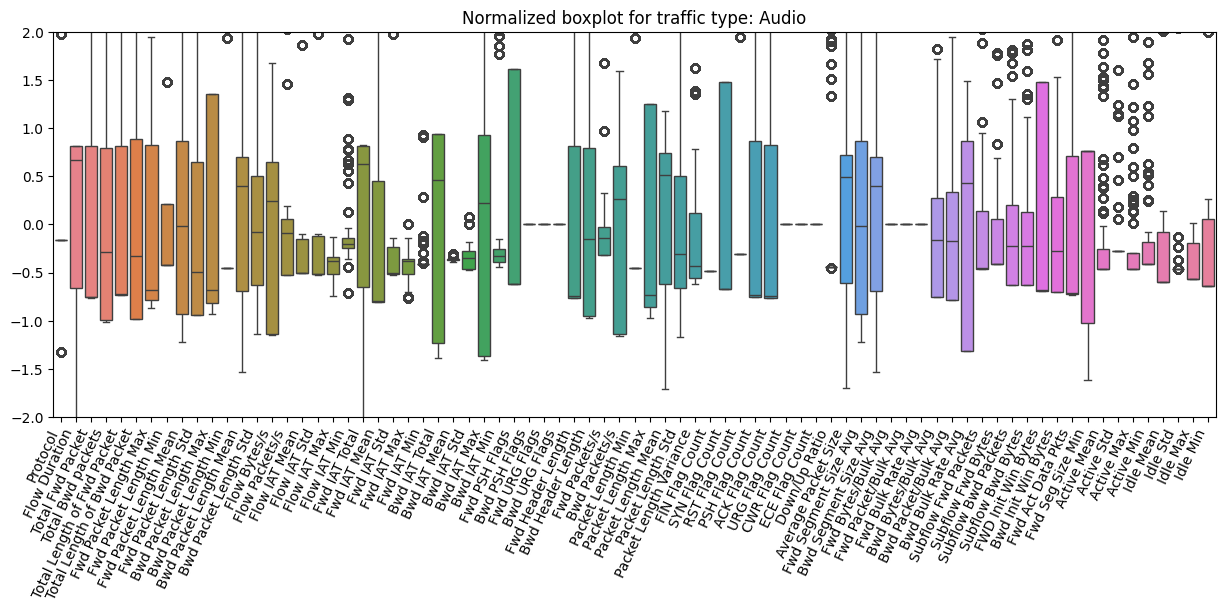

Generating boxplot ...


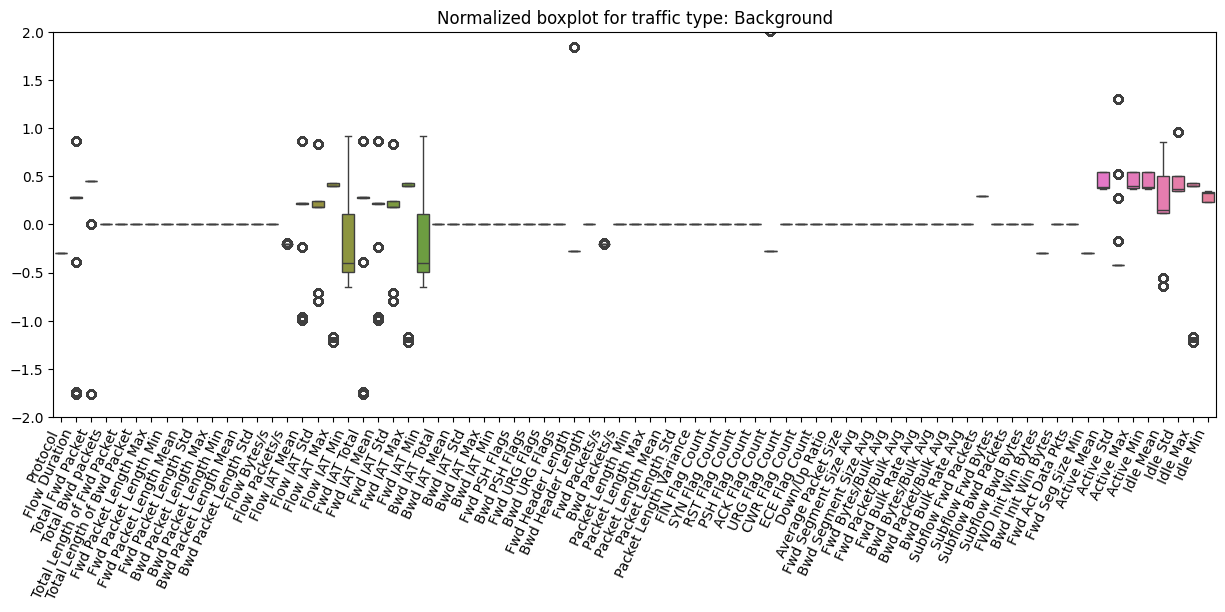

Generating boxplot ...


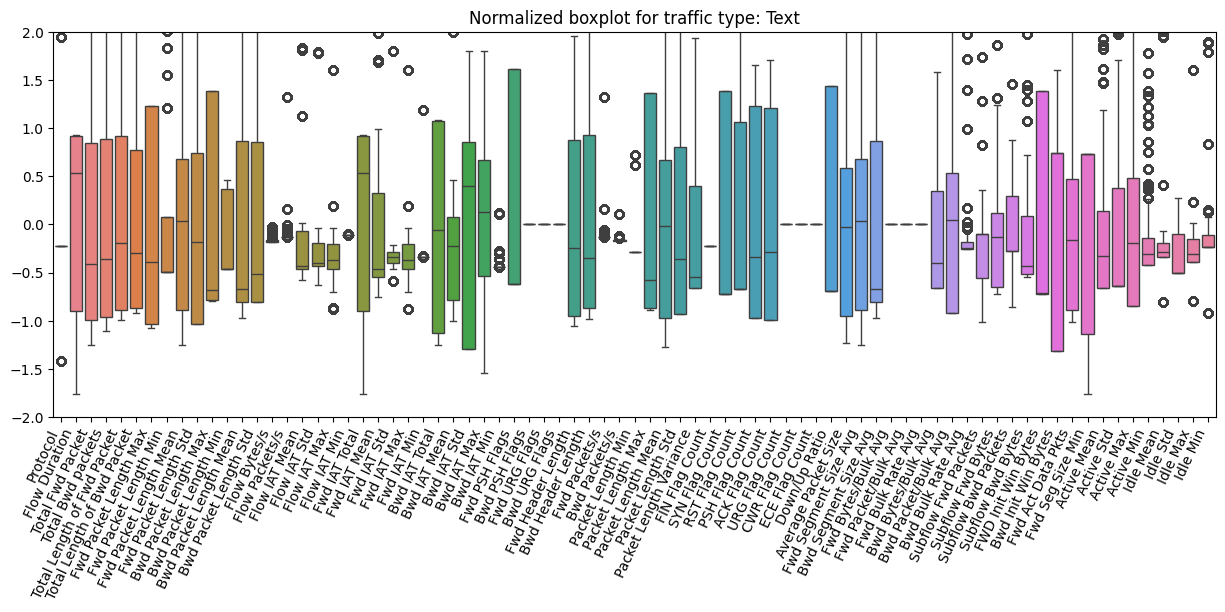

Generating boxplot ...


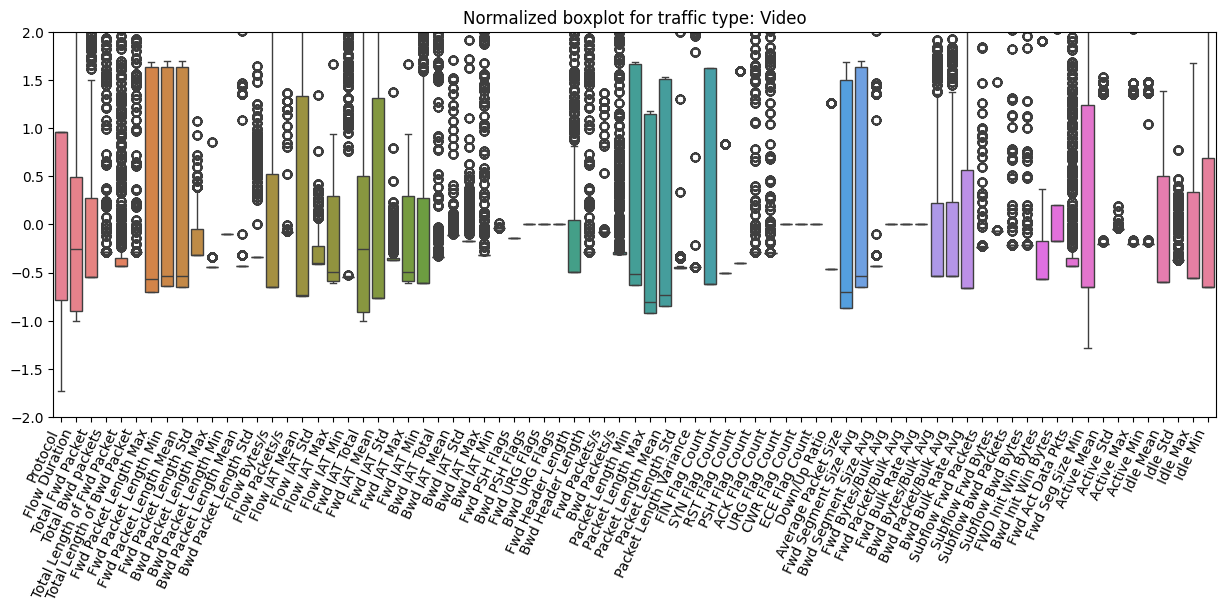

Generating boxplot ...


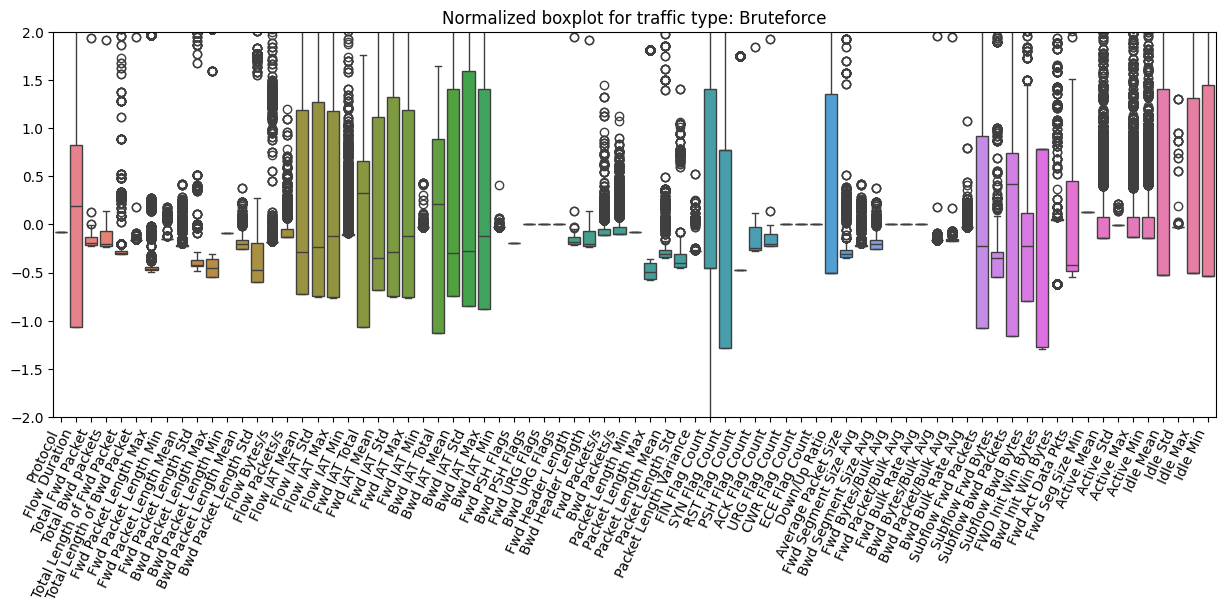

Generating boxplot ...


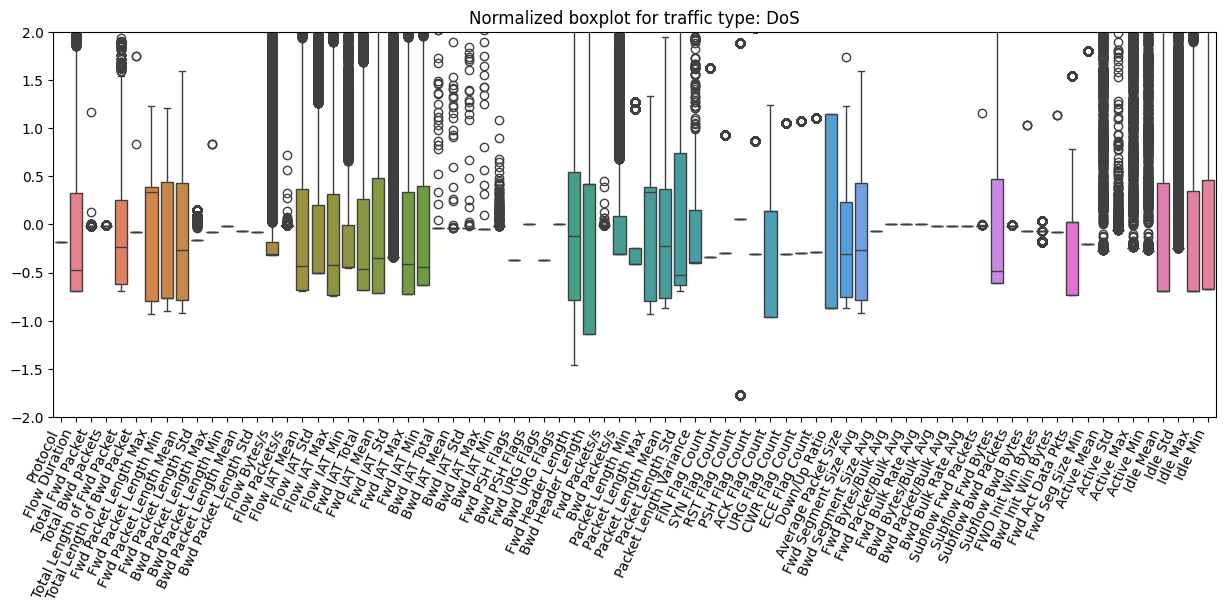

Generating boxplot ...


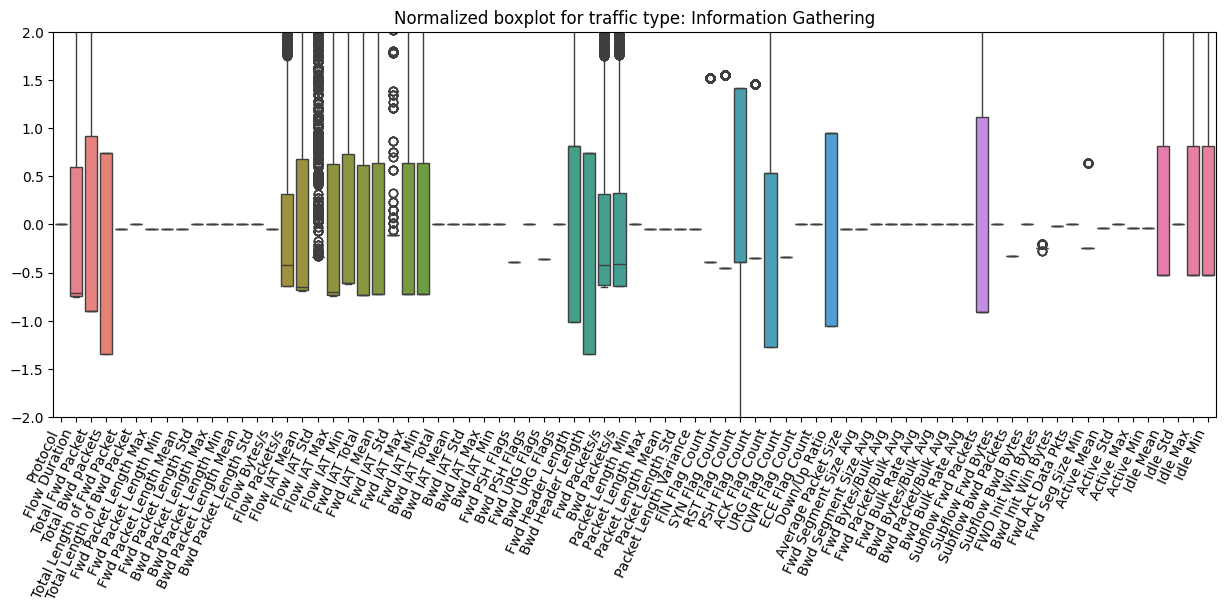

Generating boxplot ...


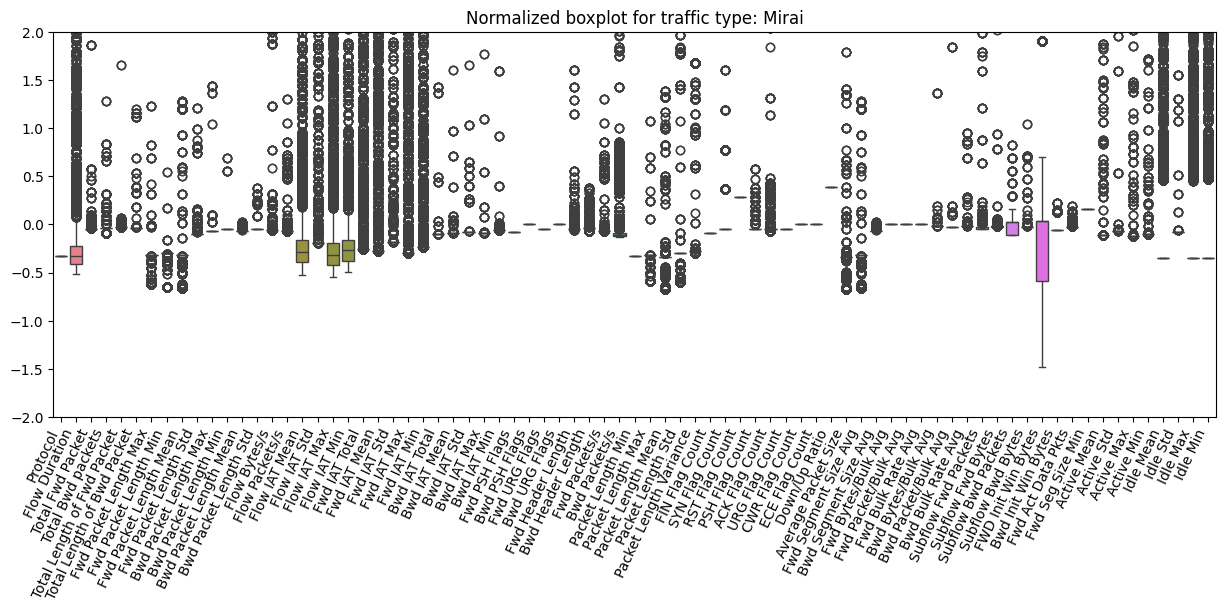

Generating boxplot ...


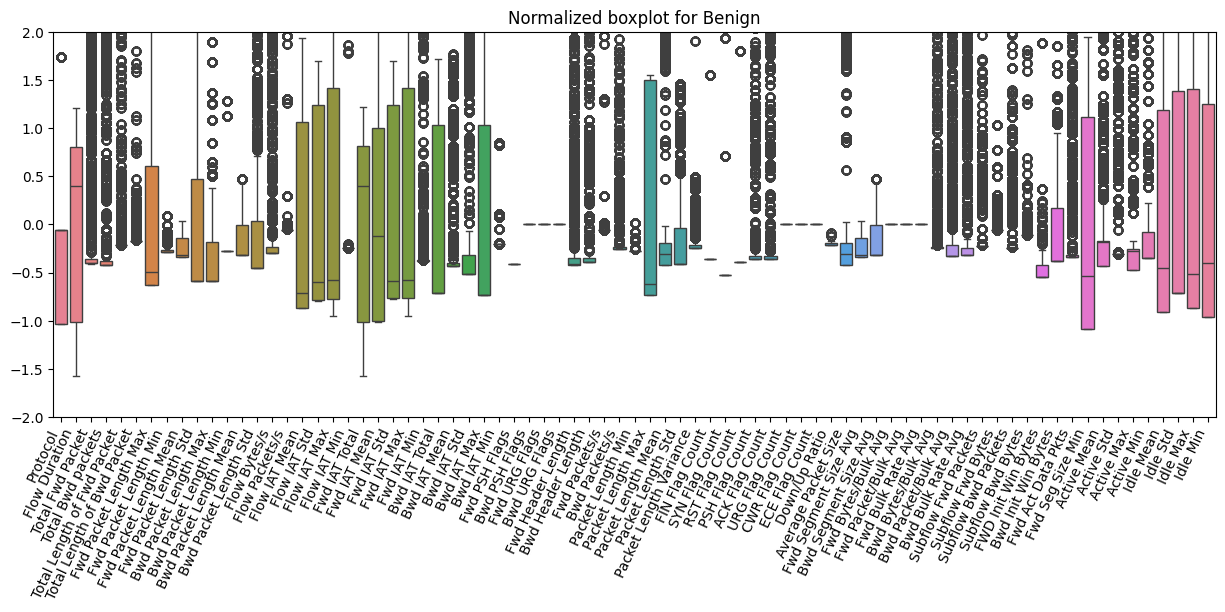

Generating boxplot ...


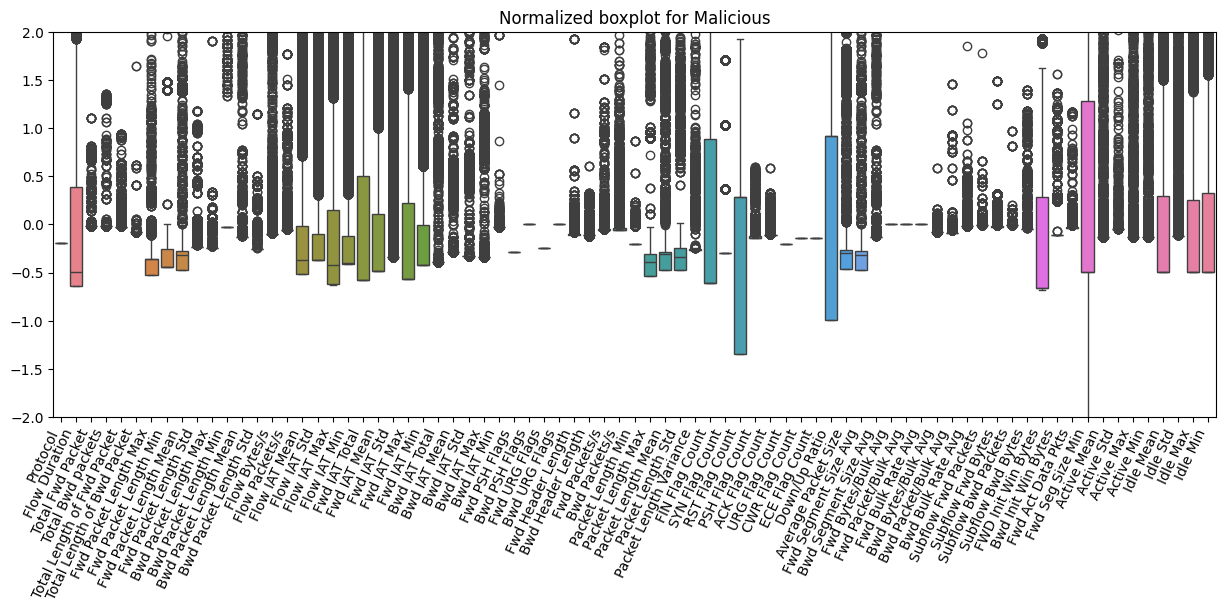

In [9]:
### Present distributions for all metrics for both Benign and Malicious labels
ylim_top = 2
ylim_bot = -2
df_benign = df_label[df_label["Label"] == "Benign"]
df_malicious = df_label[df_label["Label"] == "Malicious"]

for ttype in ttype_list:
    boxplot(df_ttype[df_ttype["Traffic Type"] == ttype].drop(columns=TARGET_LABELS), "Normalized boxplot for traffic type: " + ttype, ylim_bot, ylim_top, df_ttype.columns.tolist()[:-3])

boxplot(df_benign.drop(columns=TARGET_LABELS), "Normalized boxplot for Benign", ylim_bot, ylim_top, df_ttype.columns.tolist()[:-3])
boxplot(df_malicious.drop(columns=TARGET_LABELS), "Normalized boxplot for Malicious", ylim_bot, ylim_top, df_ttype.columns.tolist()[:-3])

In [10]:
# Convert all data to numerical and compute correlations
df_num_label = labels_to_numerical(df_label, LABEL_MAPPER)
df_num_label = ttypes_to_numerical(df_num_label, TYPES_MAPPER)
df_num_label = subtypes_to_numerical(df_num_label, SUBTYPES_MAPPER).select_dtypes(include="number")

df_num_ttype = labels_to_numerical(df_ttype, LABEL_MAPPER)
df_num_ttype = ttypes_to_numerical(df_num_ttype, TYPES_MAPPER)
df_num_ttype = subtypes_to_numerical(df_num_ttype, SUBTYPES_MAPPER).select_dtypes(include="number")

cor = correlation(df_num_label, target = "Label")
cor_label, important_metrics_label = correlation(df_num_label, target = "Label", with_target=True)
cor_ttype, important_metrics_ttype = correlation(df_num_ttype, target = "Traffic Type", with_target=True)

label_barplot = important_metrics_label.copy()
label_barplot.remove("Traffic Type")
label_barplot.remove("Traffic Subtype")
ttype_barplot = important_metrics_ttype.copy()
ttype_barplot.remove("Label")
ttype_barplot.remove("Traffic Subtype")

28 Metrics with high correlation with Label
27 Metrics with high correlation with Label


Generating heatmap ...


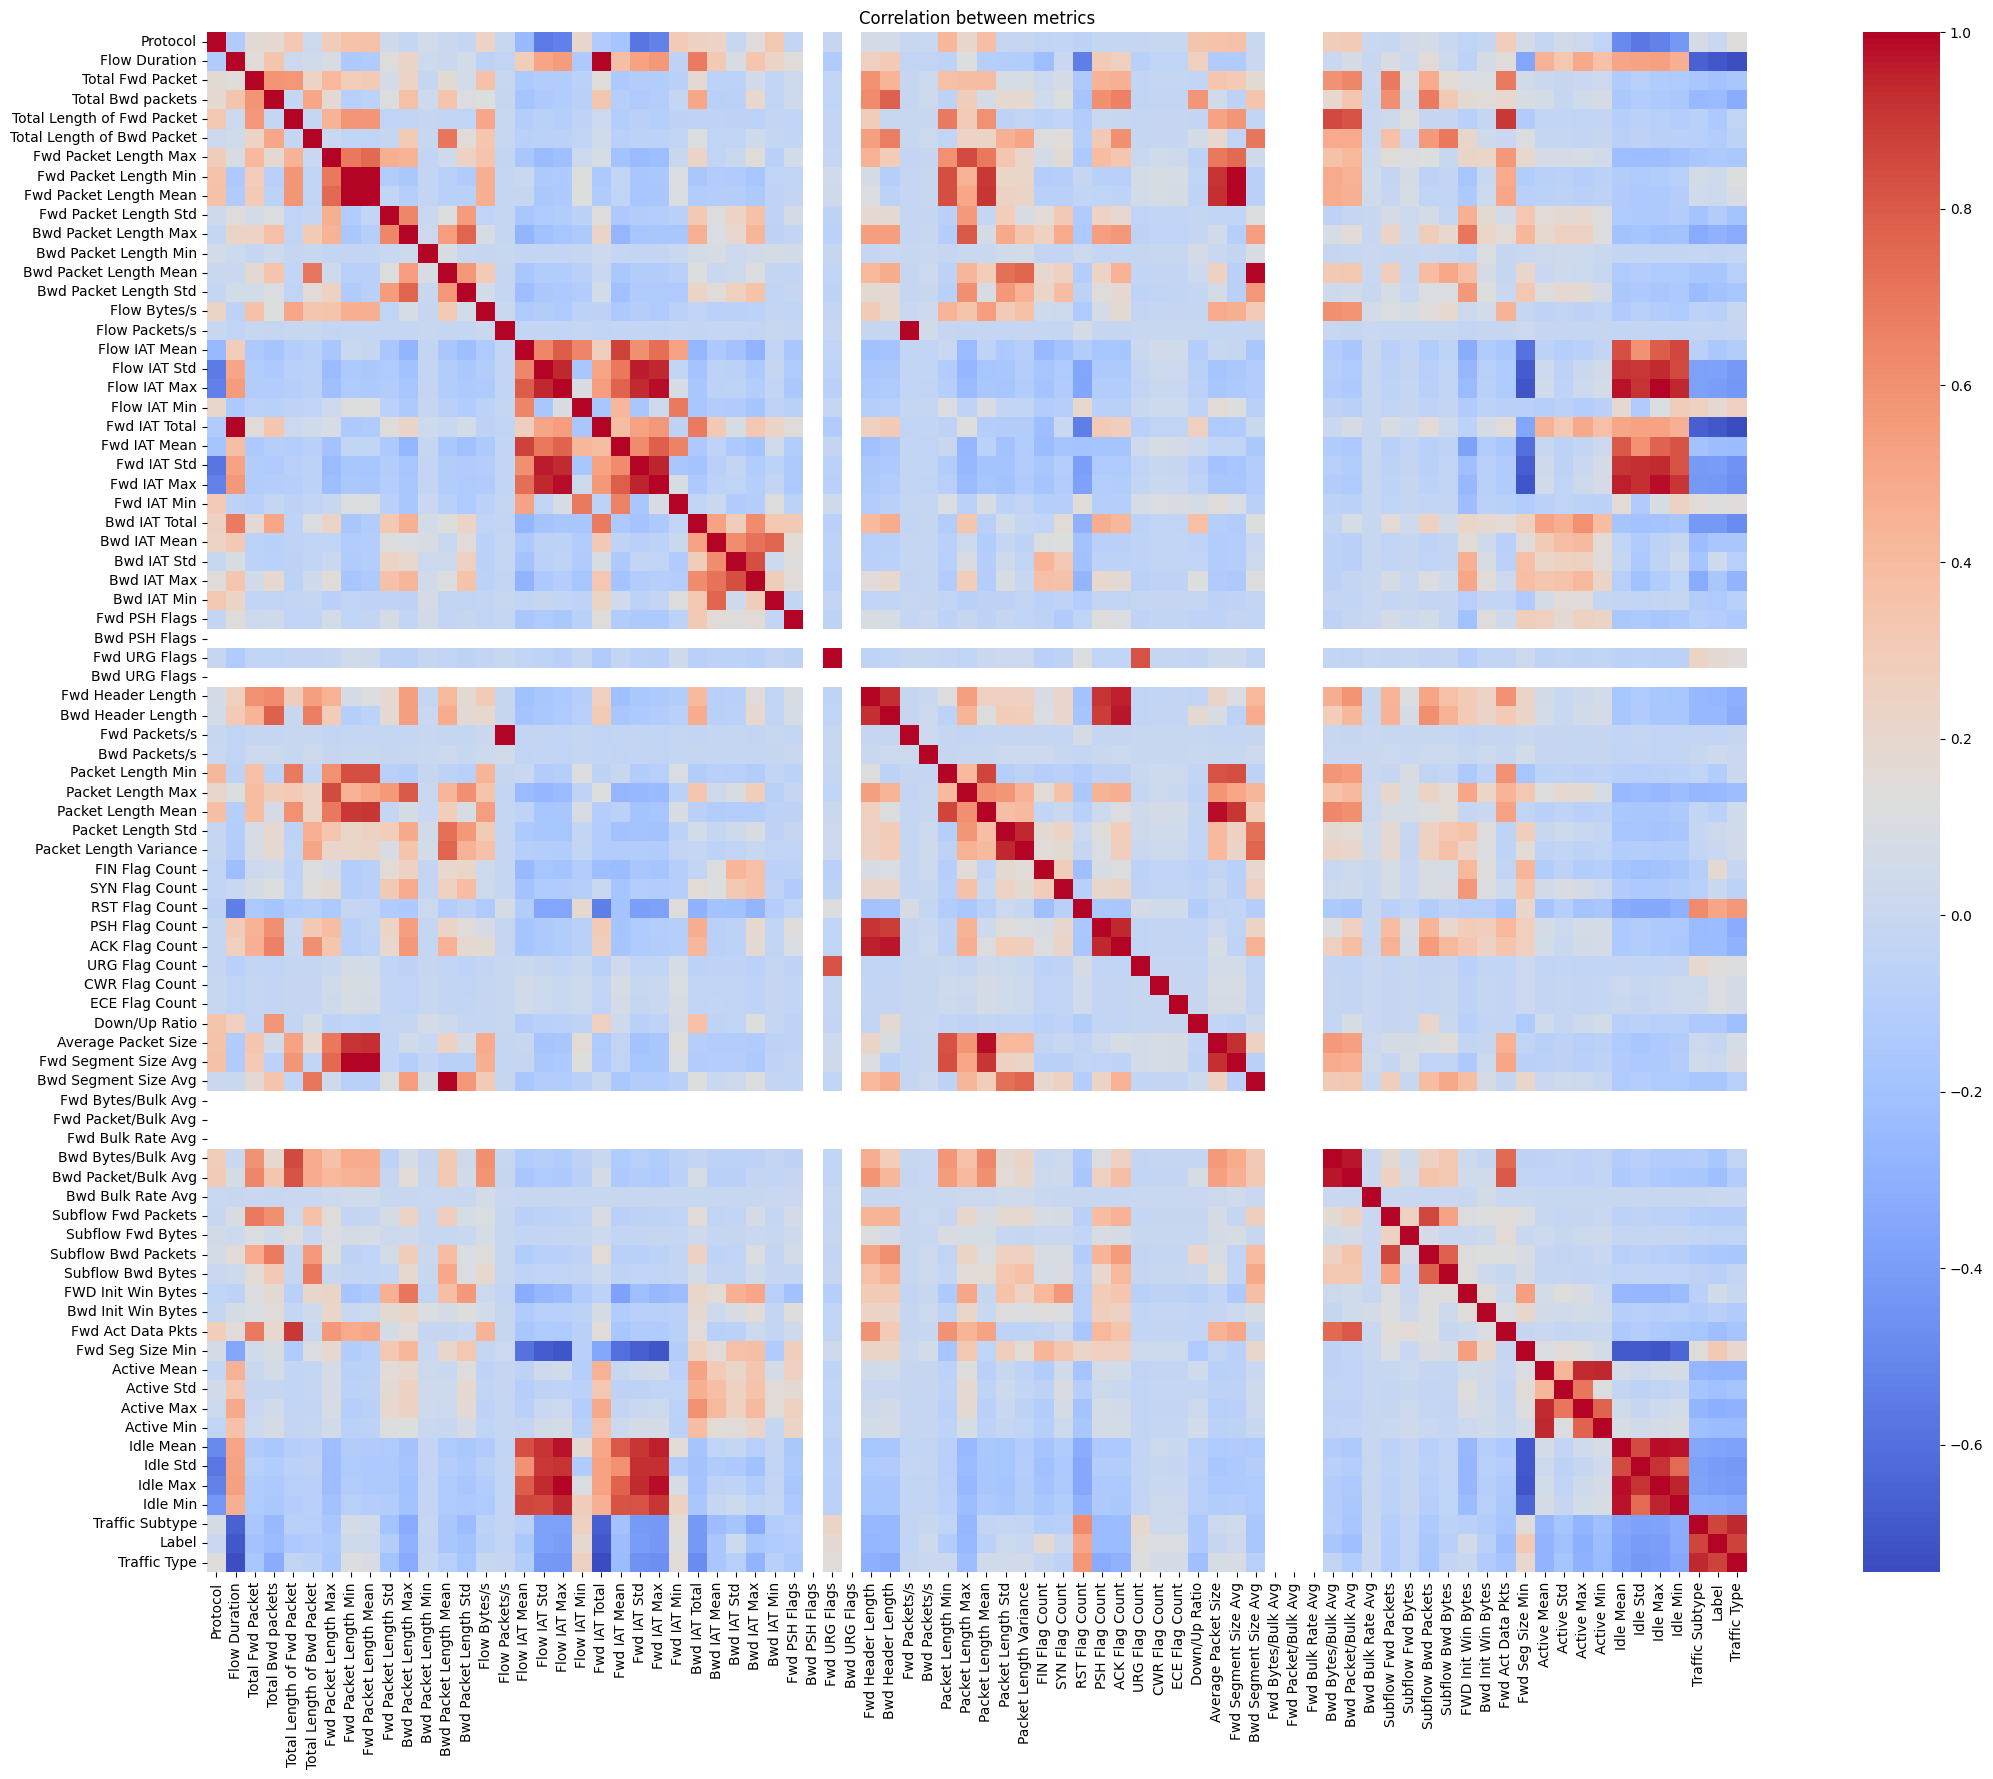

Generating heatmap ...


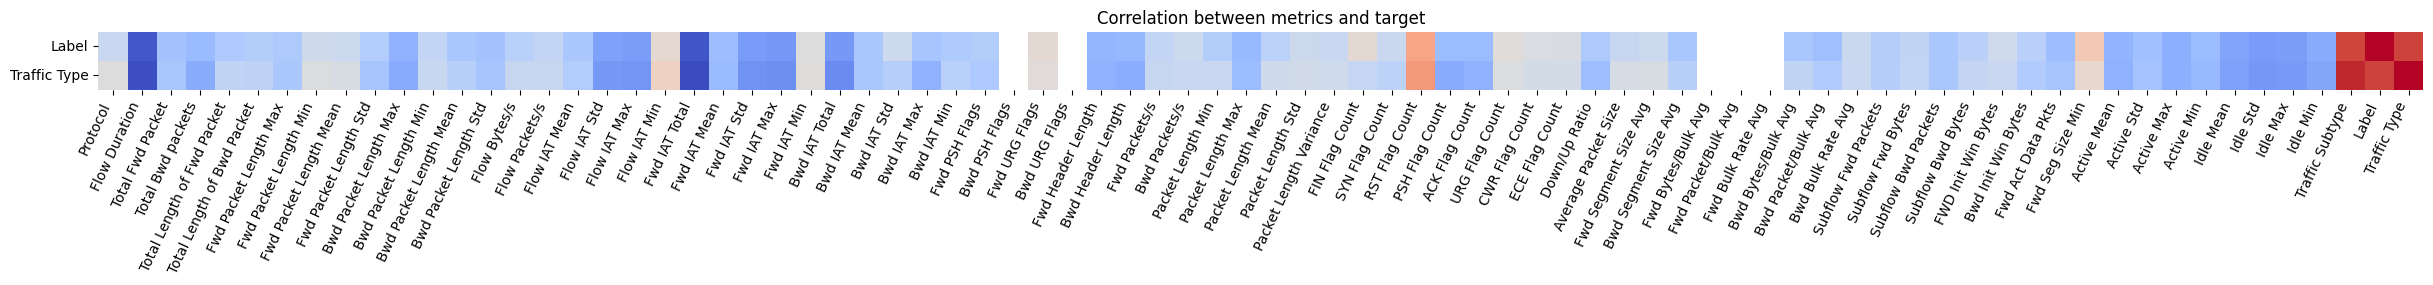

In [11]:
### Create heatmaps
general_correlation = {"Correlation": cor}
heatmap(general_correlation, "Correlation between metrics")

targeted_correlation = {"Label": cor_label, "Traffic Type": cor_ttype}
heatmap(targeted_correlation, "Correlation between metrics and target", with_target=True)

Generating barplot ...


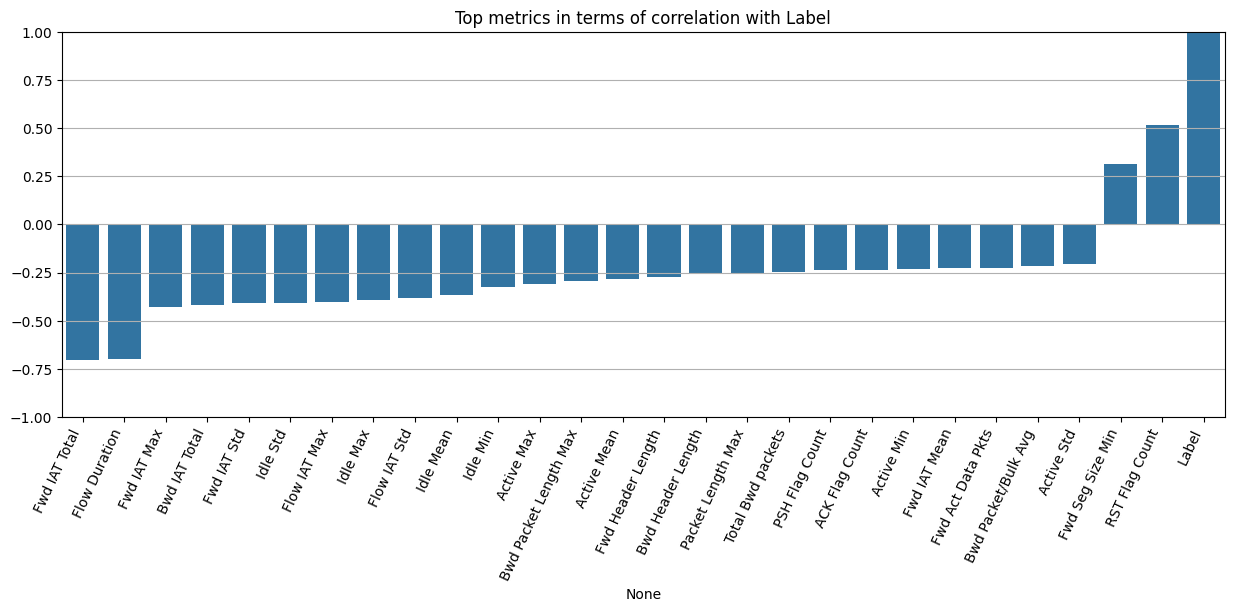

Generating barplot ...


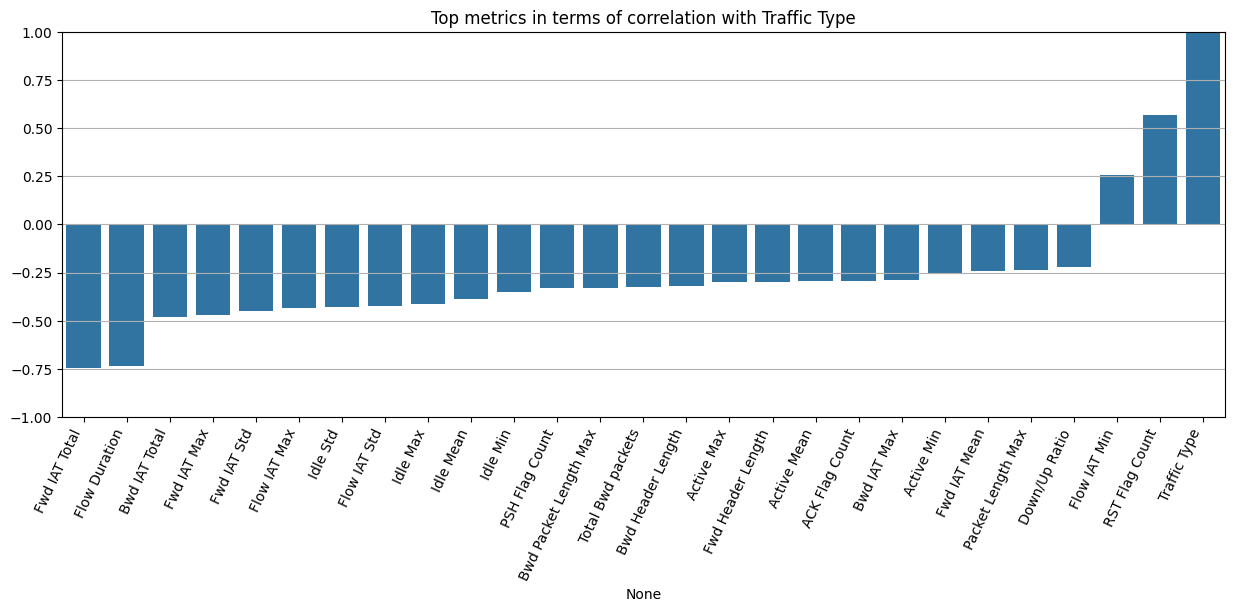

In [12]:
### Showcase top correlations
df_important_metrics_label_count = cor_label.filter(items=label_barplot, axis="index").filter(["Label"]).sort_values(by="Label")
barplot(
    df_important_metrics_label_count.index, df_important_metrics_label_count.values.reshape(len(df_important_metrics_label_count.index)),
    "Top metrics in terms of correlation with Label"
)

df_important_metrics_ttype_count = cor_ttype.filter(items=ttype_barplot, axis="index").filter(["Traffic Type"]).sort_values(by="Traffic Type")
barplot(
    df_important_metrics_ttype_count.index, df_important_metrics_ttype_count.values.reshape(len(df_important_metrics_ttype_count.index)),
    "Top metrics in terms of correlation with Traffic Type"
)

In [13]:
### DataFrames with metrics highly correlated with targets, dimension reduction
DIM_TARGET1 = 10
DIM_TARGET2 = 10
df_label = df_num_label[important_metrics_label].copy()
df_ttype = df_num_ttype[important_metrics_ttype].copy()

print("Target Label:")
df_labelDimReduction = dim_reduction(df_label.drop(columns=["Label", "Traffic Type", "Traffic Subtype"]), DIM_TARGET1, "PCA")
df_labelDimReduction["Label"] = df_label["Label"]
df_labelDimReduction["Traffic Type"] = df_label["Traffic Type"]
df_labelDimReduction["Traffic Subtype"] = df_label["Traffic Subtype"]
print("Target Traffic Type:")
df_ttypeDimReduction = dim_reduction(df_ttype.drop(columns=["Label", "Traffic Type", "Traffic Subtype"]), DIM_TARGET2, "PCA")
df_ttypeDimReduction["Label"] = df_ttype["Label"]
df_ttypeDimReduction["Traffic Type"] = df_ttype["Traffic Type"]
df_ttypeDimReduction["Traffic Subtype"] = df_ttype["Traffic Subtype"]


Target Label:
PCA METHOD --> Cumulative variance: 0.9641835073595658
Target Traffic Type:
PCA METHOD --> Cumulative variance: 0.9682268881622321


In [14]:
### Sampling, Clustering with BIRCH, Clustering with HDBSCAN
# Data reduction through sampling
df_label_sampling = sampling(df_labelDimReduction, 0, 0.3, notext=True)
df_ttype_sampling = sampling(df_ttypeDimReduction, 0, 0.3, notext=True)

# Data reduction through BIRCH clustering
print("\nBIRCH with target: Label")
df_label_BIRCH = BIRCH_clustering(df_labelDimReduction.drop(columns=["Label", "Traffic Type", "Traffic Subtype"]), 700, threshold=0.1)
df_label_BIRCH["Label"] = df_labelDimReduction["Label"]
print("\nBIRCH with target: Traffic Type")
df_ttype_BIRCH = BIRCH_clustering(df_ttypeDimReduction.drop(columns=["Label", "Traffic Type", "Traffic Subtype"]), 2500, threshold=0.1)
df_ttype_BIRCH["Traffic Type"] = df_ttypeDimReduction["Traffic Type"]

# Data reduction through DBSCAN clustering
print("\nDBSCAN with target: Label")
df_label_DBSCAN = DBSCAN_algorithm(df_labelDimReduction.drop(columns=["Label", "Traffic Type", "Traffic Subtype"]), 0.02, 25)
df_label_DBSCAN["Label"] = df_labelDimReduction["Label"]
print("\nDBSCAN with target: Traffic Type")
df_ttype_DBSCAN = DBSCAN_algorithm(df_ttypeDimReduction.drop(columns=["Label", "Traffic Type", "Traffic Subtype"]), 0.0004, 5)
df_ttype_DBSCAN["Traffic Type"] = df_ttypeDimReduction["Traffic Type"]

# Data reduction through HDBSCAN clustering
print("\nHDBSCAN with target: Label")
df_label_HDBSCAN = HDBSCAN_clustering(df_labelDimReduction.drop(columns=["Label", "Traffic Type", "Traffic Subtype"]), 50)
df_label_HDBSCAN["Label"] = df_labelDimReduction["Label"]
print("\nHDBSCAN with target: Traffic Type")
df_ttype_HDBSCAN = HDBSCAN_clustering(df_ttypeDimReduction.drop(columns=["Label", "Traffic Type", "Traffic Subtype"]), 10)
df_ttype_HDBSCAN["Traffic Type"] = df_ttypeDimReduction["Traffic Type"]


BIRCH with target: Label
700 Clusters
Davies-Bouldin Index: 0.16983658788648956

BIRCH with target: Traffic Type
2500 Clusters
Davies-Bouldin Index: 0.035354067458751436

DBSCAN with target: Label
638 Clusters
Davies-Bouldin Index: 0.026365450067414854

DBSCAN with target: Traffic Type
2812 Clusters
Davies-Bouldin Index: 0.007959570339635909

HDBSCAN with target: Label
764 Clusters
Davies-Bouldin Index: 0.06977515680498195

HDBSCAN with target: Traffic Type
3443 Clusters
Davies-Bouldin Index: 0.026822315176220055


BIRCH, target = Label:
Problematic Cluster - Ratio: 1.286%
Population that belongs to Problematic Clusters - Ratio: 14.828%
Clusters assigned to each Label: {0: 184, 1: 516}
Problematic Clusters assigned to each Label: {0: 6, 1: 3}
Total Clusters: 700
Empty clusters: 0
Total Population predicted per Target: {0: 79379, 1: 85799}
Real Population per Target: {0: 85124, 1: 80054}


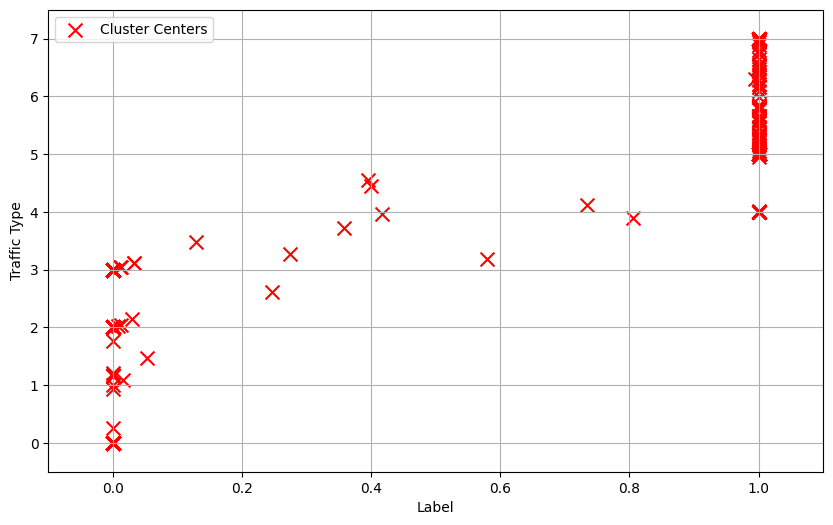

BIRCH, target = Traffic Type:
Problematic Cluster - Ratio: 4.200%
Population that belongs to Problematic Clusters - Ratio: 40.294%
Clusters assigned to each Traffic Type: {0: 98, 1: 4, 2: 88, 3: 139, 4: 39, 5: 1936, 6: 48, 7: 148}
Problematic Clusters assigned to each Traffic Type: {0: 2, 1: 3, 2: 3, 3: 5, 4: 2, 5: 23, 6: 34, 7: 33}
Total Clusters: 2500
Empty clusters: 0
Total Population predicted per Target: {0: 16660, 1: 25397, 2: 18653, 3: 15827, 4: 19160, 5: 14261, 6: 31975, 7: 17997}
Real Population per Target: {0: 20095, 1: 19953, 2: 19961, 3: 19945, 4: 19961, 5: 19992, 6: 20045, 7: 19978}


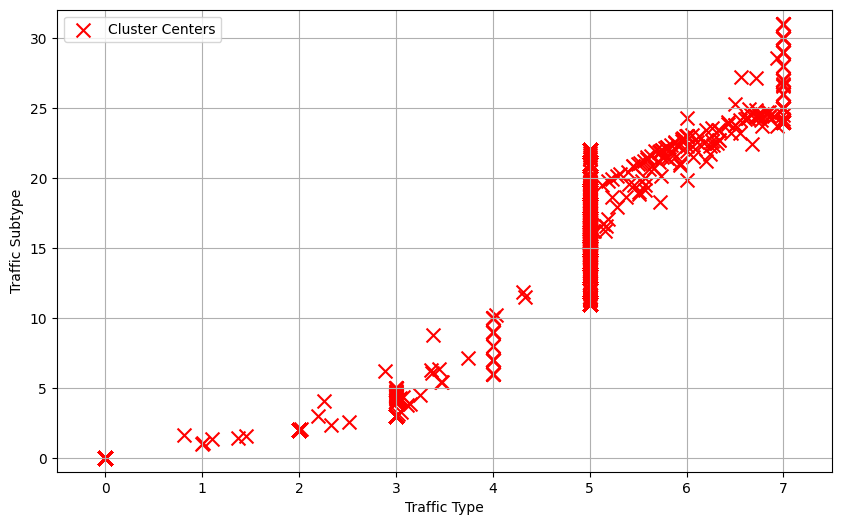

DBSCAN, target = Label:
Problematic Cluster - Ratio: 0.470%
Population that belongs to Problematic Clusters - Ratio: 4.114%
Clusters assigned to each Label: {0: 523, 1: 114}
Problematic Clusters assigned to each Label: {0: 1, 1: 2}
Total Clusters: 638
Empty clusters: 1
Total Population predicted per Target: {0: 83150, 1: 70053}
Real Population per Target: {0: 85124, 1: 80054}


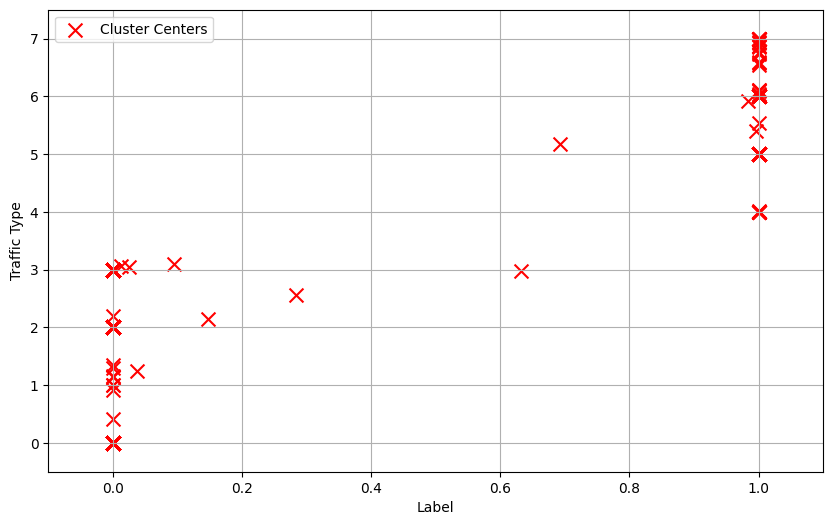

DBSCAN, target = Traffic Type:
Problematic Cluster - Ratio: 1.209%
Population that belongs to Problematic Clusters - Ratio: 3.026%
Clusters assigned to each Traffic Type: {0: 125, 1: 21, 2: 136, 3: 488, 4: 284, 5: 114, 6: 873, 7: 770}
Problematic Clusters assigned to each Traffic Type: {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 7, 6: 0, 7: 23}
Total Clusters: 2812
Empty clusters: 1
Total Population predicted per Target: {0: 19299, 1: 20173, 2: 21676, 3: 18077, 4: 13714, 5: 8868, 6: 20296, 7: 18809}
Real Population per Target: {0: 20095, 1: 19953, 2: 19961, 3: 19945, 4: 19961, 5: 19992, 6: 20045, 7: 19978}


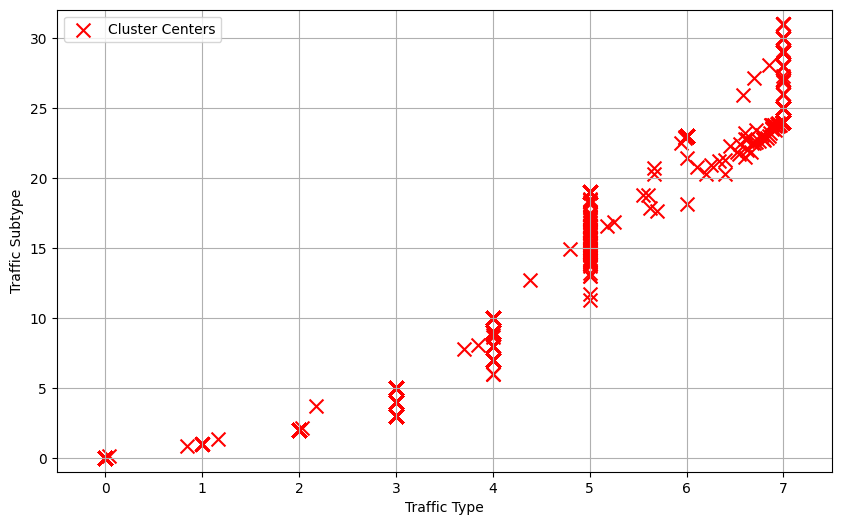

HDBSCAN, target = Traffic Type:
Problematic Cluster - Ratio: 1.830%
Population that belongs to Problematic Clusters - Ratio: 0.901%
Clusters assigned to each Label: {0: 484, 1: 280}
Problematic Clusters assigned to each Label: {0: 14, 1: 0}
Total Clusters: 765
Empty clusters: 1
Total Population predicted per Target: {0: 82941, 1: 61584}
Real Population per Target: {0: 85124, 1: 80054}


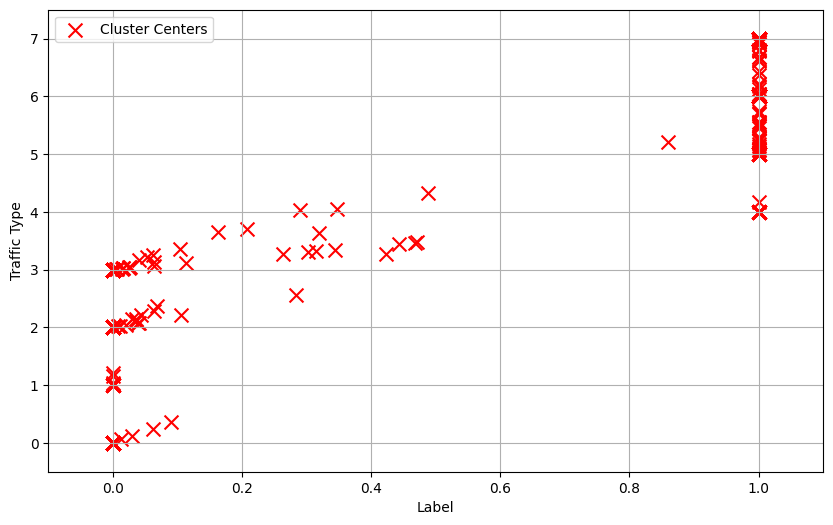

HDBSCAN, target = Traffic Type:
Problematic Cluster - Ratio: 5.226%
Population that belongs to Problematic Clusters - Ratio: 2.732%
Clusters assigned to each Traffic Type: {0: 131, 1: 25, 2: 144, 3: 573, 4: 315, 5: 427, 6: 913, 7: 915}
Problematic Clusters assigned to each Traffic Type: {0: 0, 1: 0, 2: 1, 3: 10, 4: 5, 5: 43, 6: 22, 7: 99}
Total Clusters: 3444
Empty clusters: 1
Total Population predicted per Target: {0: 20124, 1: 19953, 2: 20093, 3: 20051, 4: 13397, 5: 12916, 6: 17644, 7: 17794}
Real Population per Target: {0: 20095, 1: 19953, 2: 19961, 3: 19945, 4: 19961, 5: 19992, 6: 20045, 7: 19978}


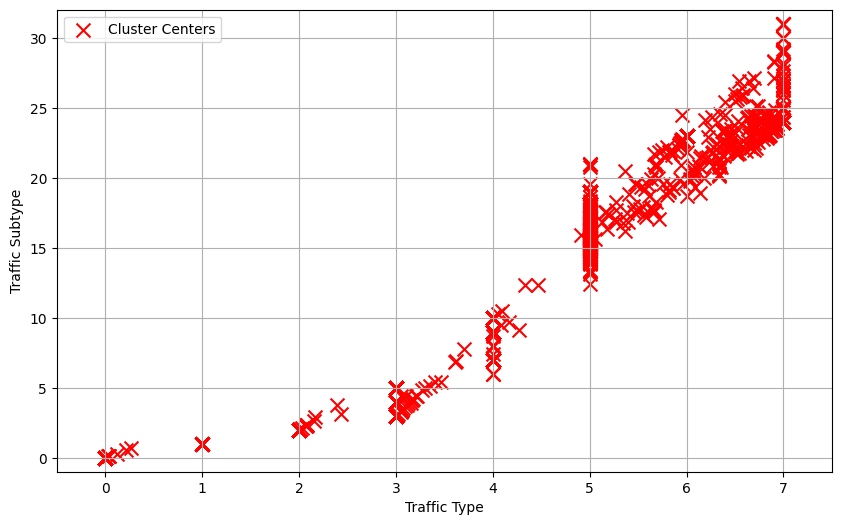

In [15]:
### Visualize clusters
df_label_BIRCH_plot = df_label_BIRCH.copy()
df_label_BIRCH_plot["Traffic Type"] = df_labelDimReduction["Traffic Type"]
df_label_BIRCH_plot["Traffic Subtype"] = df_labelDimReduction["Traffic Subtype"]

df_ttype_BIRCH_plot = df_ttype_BIRCH.copy()
df_ttype_BIRCH_plot["Label"] = df_ttypeDimReduction["Label"]
df_ttype_BIRCH_plot["Traffic Subtype"] = df_ttypeDimReduction["Traffic Subtype"]

df_label_DBSCAN_plot = df_label_DBSCAN.copy()
df_label_DBSCAN_plot["Traffic Type"] = df_labelDimReduction["Traffic Type"]
df_label_DBSCAN_plot["Traffic Subtype"] = df_labelDimReduction["Traffic Subtype"]

df_ttype_DBSCAN_plot = df_ttype_DBSCAN.copy()
df_ttype_DBSCAN_plot["Label"] = df_ttypeDimReduction["Label"]
df_ttype_DBSCAN_plot["Traffic Subtype"] = df_ttypeDimReduction["Traffic Subtype"]

df_label_HDBSCAN_plot = df_label_HDBSCAN.copy()
df_label_HDBSCAN_plot["Traffic Type"] = df_labelDimReduction["Traffic Type"]
df_label_HDBSCAN_plot["Traffic Subtype"] = df_labelDimReduction["Traffic Subtype"]

df_ttype_HDBSCAN_plot = df_ttype_HDBSCAN.copy()
df_ttype_HDBSCAN_plot["Label"] = df_ttypeDimReduction["Label"]
df_ttype_HDBSCAN_plot["Traffic Subtype"] = df_ttypeDimReduction["Traffic Subtype"]

print("BIRCH, target = Label:")
evaluate_clusters(df_label_BIRCH_plot, "Label", "Traffic Type", 2)
print("BIRCH, target = Traffic Type:")
evaluate_clusters(df_ttype_BIRCH_plot, "Traffic Type", "Traffic Subtype", 8, cluster_ratio_cap=0.15)

print("DBSCAN, target = Label:")
evaluate_clusters(df_label_DBSCAN_plot, "Label", "Traffic Type", 2)
print("DBSCAN, target = Traffic Type:")
evaluate_clusters(df_ttype_DBSCAN_plot, "Traffic Type", "Traffic Subtype", 8, cluster_ratio_cap=0.15)

print("HDBSCAN, target = Traffic Type:")
evaluate_clusters(df_label_HDBSCAN_plot, "Label", "Traffic Type", 2)
print("HDBSCAN, target = Traffic Type:")
evaluate_clusters(df_ttype_HDBSCAN_plot, "Traffic Type", "Traffic Subtype", 8, cluster_ratio_cap=0.15)